Plurality voting is done by considering the prediction of each individual classifier in the ensemble for a label, and taking in the class/label/candidate with the most votes (the mode of votes).

Let's consider an ensemble of $n$ classifiers with individual error probabilities of $\varepsilon$ (uniform, for the sake of argument). Then the probability that the ensemble will have $m$ incorrect predictions ~ $\mathrm{Bin}(n, m, \varepsilon)$. Namely, $$P(N_{errors}\geq k) = \sum_{m = k}^{n} \binom{n}{m} \varepsilon^m (1- \varepsilon)^{n-m}.$$ For $\varepsilon < 0.5$ (better than individual classifiers that are randomly guessing), and considering $k~ \mathcal(n/2)$, we get the ensemble error being significantly reduced relative to the individual errors. However, the classifiers do need to be distinct enough to not always make the same mistakes.

$$\mathrm{E}[MSE_{ensemble}^2] = \mathrm{E}[\left(\frac{1}{n} \sum_{i = 1}^n f_i(X) - y\right)^2] = \frac{1}{n^2}\sum_{i = 1}^n\mathrm{E}[\left( f_i(X) - y\right)^2] + \frac{1}{n^2}\sum_{i \neq j}^n\mathrm{E}[\left( f_i(X) - y\right)\left( f_j(X) - y\right)] = \frac{1}{n^2}\sum_{i = 1}^n\mathrm{E}[MSE_i] + \frac{1}{n^2}\sum_{i \neq j}^n \mathrm{Cov}(f_i(X), f_j(X)) = \frac{1}{n} \overline{MSE} + \frac{n(n-1)}{n^2} \sigma_{cov} = \frac{1}{n} \overline{MSE} + \frac{n-1}{n} \sigma_{cov}$$

There are 2 major factors at play here. 
1) In the case of uncorrelated classifiers, the ensemble MSE enjoys a reduction factor proportional to the number of classifiers used, relative to their mean MSE.

2) In the case of large $n$, the correlation of the classifiers dominates, and is the only thing that matters asymptotically.

In general, an ensemble of uncorrelated classifiers will do significantly better than a regular classifier. This isn't necessarily just for the MSE, an may be extended to other cost functions.

In [1]:
from scipy.special import comb
import math
import numpy as np
import matplotlib.pyplot as plt

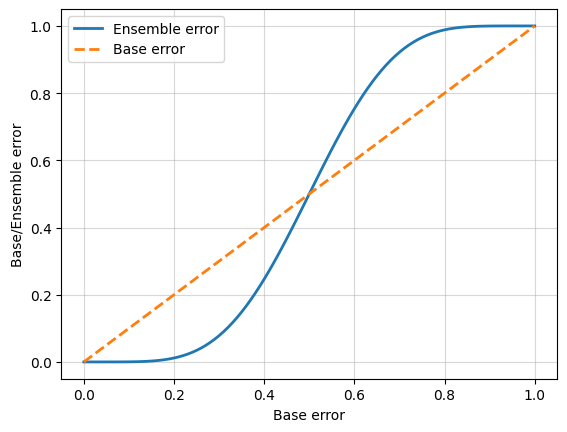

In [2]:
def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.))
    probs = [comb(n_classifier, k) *
             error**k *
             (1 - error)**(n_classifier - k)
             for k in range(k_start, n_classifier + 1)]
    return sum(probs)

error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error) for error in error_range]

plt.plot(error_range, ens_errors, label='Ensemble error', linewidth=2)
plt.plot(error_range, error_range, linestyle='--', label='Base error', linewidth=2)
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show()


A majority or plurality vote can also very easily be weighted: $$f_{ensemble}(x) = \mathrm{argmax}_i \sum_{j = 1}^n w_j\, \chi_A \left(C_j(x) = i \right) $$
Here, $w_j$ is the weight given to classifier $C_j$, and $\chi_A$ is an indicator function that indicates whether $C_j(x) = i$ (i.e. the $j^{th}$ classifier predics $i$).

Some classifiers predict a probability for all possible classes. We can then use the probabilities instead of using the direct class predictions. This takes the form: $$f_{ensemble}(x) = \mathrm{argmax}_i \sum_{j = 1}^n w_j\, p_{ij},$$ where $p_{ij}$ is the prediction of classifier $j$ in the ensemble for the probability of $x$ belonging to class $i$.

In [3]:
# The first method can be done with numpy, for example
# Let's say that Classifiers 1, 2, 3 predict 0, 0, 1, for example, and we want to weight their predictions with 0.1, 0.3 and 0.6
print(np.argmax(np.bincount([0, 0, 1], weights=[0.1, 0.3, 0.6])))

# The second method can be done with numpy as well:
# Say there are 2 classes and 3 classifiers which predict probs [p_0 and p_1]
ex = np.array([
    [0.9, 0.1],
    [0.8, 0.2],
    [0.4, 0.6]
])
p = np.average(ex, axis=0, weights=[0.1, 0.3, 0.6]) # probability of each one weighted by classifiers
print(p)
print(np.argmax(p))

1
[0.57 0.43]
0


In [4]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import Pipeline

from ensemble_majority import ClassifierMajority

rnd_state = 1

In [5]:
iris_data = datasets.load_iris()
# Load dataset for flower classification, skipping over the first flower
X = iris_data.data[50:, [1, 2]]
y = iris_data.target[50:]

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y, random_state=rnd_state)

In [6]:
# These should be fairly weak classifiers
lr = LogisticRegression(penalty='l2', C=0.001, solver='lbfgs', random_state=rnd_state) # Strong penalty - push params to 0
pipe_lr = Pipeline([['sc', StandardScaler()], ['clf', lr]])

dt = DecisionTreeClassifier(max_depth=1, criterion='gini', random_state=rnd_state)

knn = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski') # Euclidean norm
pipe_knn = Pipeline([['sc', StandardScaler()], ['clf', knn]])

clf_labels = ['Logistic reg', 'Decision tree', 'KNN']
clf_list = [pipe_lr, dt, pipe_knn]

for label, clf in zip(clf_labels, clf_list):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print(f"10-fold CV AUC ROC for {label}: {scores.mean():.2f} +/- {scores.std():.2f}.")

10-fold CV AUC ROC for Logistic reg: 0.92 +/- 0.15.
10-fold CV AUC ROC for Decision tree: 0.87 +/- 0.18.
10-fold CV AUC ROC for KNN: 0.85 +/- 0.13.


In [7]:
ensemble = ClassifierMajority(classifiers=[pipe_lr, dt, pipe_knn])

clf_labels.append("Ensemble")
clf_list.append(ensemble)

for label, clf in zip(clf_labels, clf_list):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print(f"10-fold CV AUC ROC for {label}: {scores.mean():.2f} +/- {scores.std():.2f}.")

10-fold CV AUC ROC for Logistic reg: 0.92 +/- 0.15.
10-fold CV AUC ROC for Decision tree: 0.87 +/- 0.18.
10-fold CV AUC ROC for KNN: 0.85 +/- 0.13.
10-fold CV AUC ROC for Ensemble: 0.98 +/- 0.05.


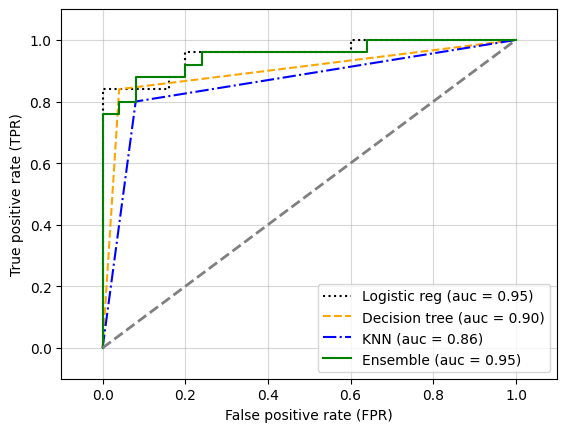

In [8]:
from sklearn.metrics import roc_curve, auc

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']

for clf, label, clr, ls in zip(clf_list, clf_labels, colors, linestyles):
    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label=f'{label} (auc = {roc_auc:.2f})')

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.show()

In [9]:
import os

original_dir = os.getcwd()
os.chdir('..')

from decision_plotting import DecisionRegionPlotter
os.chdir(original_dir)

drp = DecisionRegionPlotter()

Processed 30186 predictions in 4 batches


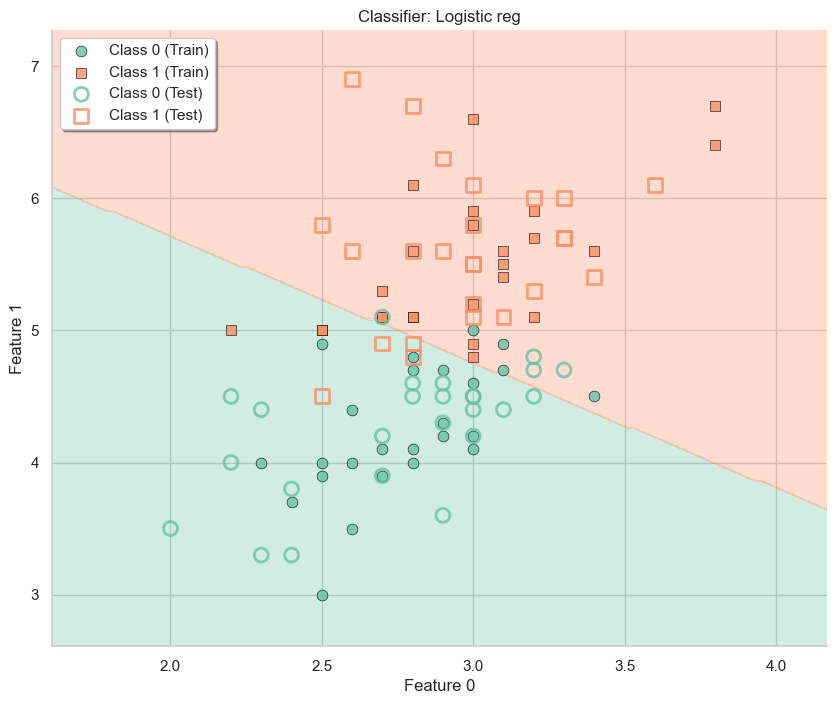

Processed 30186 predictions in 4 batches


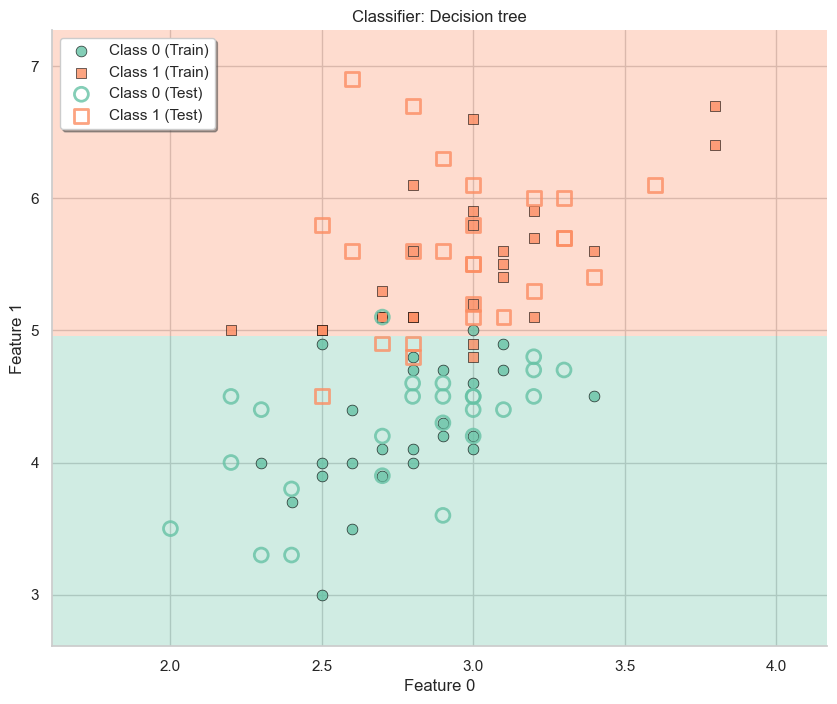

Processed 30186 predictions in 4 batches


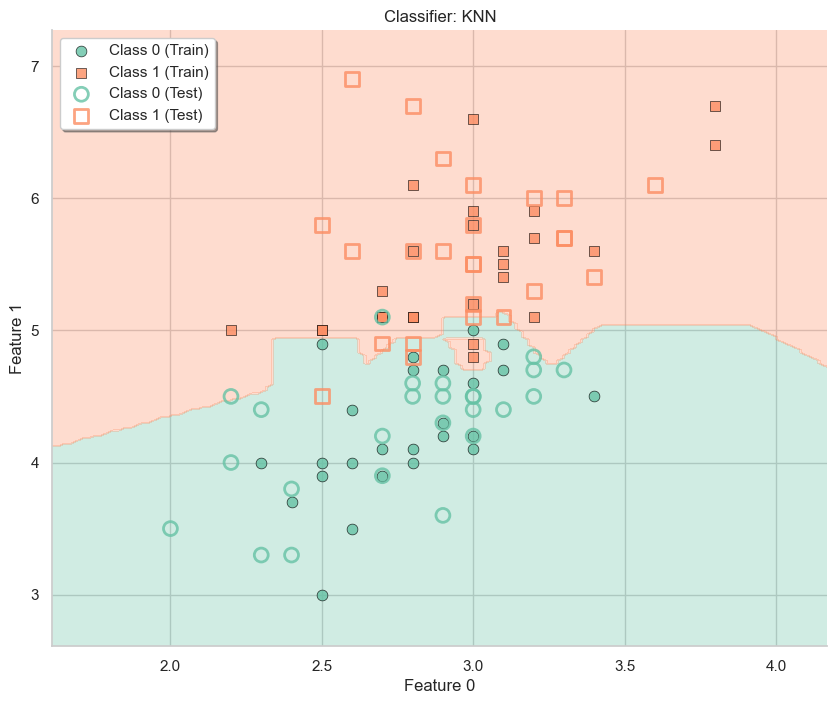

Processed 30186 predictions in 4 batches


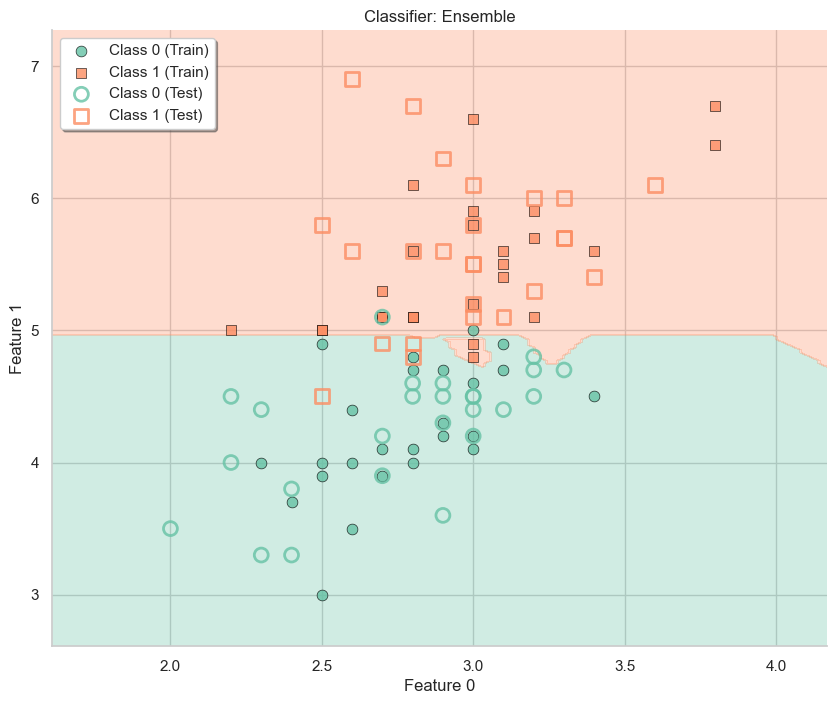

In [10]:
for label, clf in zip(clf_labels, clf_list):
    drp.plot_decision_regions(classifier=clf, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
    plt.title(f"Classifier: {label}")
    plt.show()

In [11]:
ensemble.get_params()

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(max_depth=1, random_state=1),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=0.001, random_state=1)]],
 'pipeline-1__transform_input': None,
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__clf': LogisticRegression(C=0.001, random_state=1),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__clf__C': 0.001,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,
 'pipeline-1__clf__intercept_scaling': 1,
 'pipeline-1__clf__l1_ratio': None,
 'pipeline-1__clf__max_iter': 100,
 'p

In [12]:
# Tuning the ensemble classifier
from sklearn.model_selection import GridSearchCV
params = {'decisiontreeclassifier__max_depth':[1, 2],
          'pipeline-1__clf__C': np.logspace(-2, 2, 5)}

grid = GridSearchCV(estimator=ensemble,
                    param_grid=params,
                    cv=10,
                    scoring='roc_auc').fit(X_train, y_train)


for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    mean_score = grid.cv_results_['mean_test_score'][r]
    stdev = grid.cv_results_['std_test_score'][r]
    parameters = grid.cv_results_['params'][r]

    print(f"Paramters {parameters} scored {mean_score:.3f} +/- {stdev:.3f}")

print(f'Best parameters: {grid.best_params_}')
print(f'ROC AUC : {grid.best_score_:.2f}')

Paramters {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': np.float64(0.01)} scored 0.983 +/- 0.050
Paramters {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': np.float64(0.1)} scored 0.983 +/- 0.050
Paramters {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': np.float64(1.0)} scored 0.967 +/- 0.100
Paramters {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': np.float64(10.0)} scored 0.967 +/- 0.100
Paramters {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': np.float64(100.0)} scored 0.967 +/- 0.100
Paramters {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': np.float64(0.01)} scored 0.983 +/- 0.050
Paramters {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': np.float64(0.1)} scored 0.983 +/- 0.050
Paramters {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': np.float64(1.0)} scored 0.967 +/- 0.100
Paramters {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': np.float64(10.0)} 

All of this has been implemented with sklearn.ensemble.VotingClassifier

Clearly, depth does not really have much of an impact on this. It would then be best to choose the cheapest parameters. For more complex classification problems, stacking might be a good way through - feed the results of one set of classifiers into another "layer". This has also been implemented in scikit-learn as sklearn.ensemble.StackingClassifier.